# Deep Learning Wall Detector

#### The aim is try out Image-Segmentation on a dataset <br>outside the usual ones like CamVid.

#### The data consists of French house plans from the planning<br>office and the wall masks have been prepared by the creators.

#### The dataset can be found here:
http://dag.cvc.uab.es/resources/floorplans/

Citation<br>
Authors: de las Heras, Lluis-Pere and Terrades, OriolRamos and Robles, Sergi and Sanchez, Gemma<br>
Title: CVC-FP and SGT: a new database for structural floor plan analysis and its groundtruthing tool<br>
Journal: International Journal on Document Analysis and Recognition, 2015<br>

### Imports and magics

In [1]:
from fastai.vision import *

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

### Set paths

In [4]:
path = Path('.')
data_path = path/'data'

In [5]:
data_path.ls()

[PosixPath('data/wallmasks'),
 PosixPath('data/images'),
 PosixPath('data/walllabels')]

In [6]:
image_path = data_path/'images'
mask_path = data_path/'walllabels'

### Check contents

In [7]:
#same length
print(len(image_path.ls()))
print(len(mask_path.ls()))

123
122


In [8]:
image_path.ls()[0:5]

[PosixPath('data/images/P060_000_000.png'),
 PosixPath('data/images/P113_000_000.png'),
 PosixPath('data/images/P002_000_000.png'),
 PosixPath('data/images/P109_000_000.png'),
 PosixPath('data/images/P033_000_000.png')]

In [9]:
mask_path.ls()[0:5]

[PosixPath('data/walllabels/P060_000_000.png'),
 PosixPath('data/walllabels/P113_000_000.png'),
 PosixPath('data/walllabels/P002_000_000.png'),
 PosixPath('data/walllabels/P109_000_000.png'),
 PosixPath('data/walllabels/P033_000_000.png')]

### Create lists

In [10]:
image_list = get_image_files(image_path)
type(image_list)

list

In [11]:
image_list[0:5]

[PosixPath('data/images/P060_000_000.png'),
 PosixPath('data/images/P113_000_000.png'),
 PosixPath('data/images/P002_000_000.png'),
 PosixPath('data/images/P109_000_000.png'),
 PosixPath('data/images/P033_000_000.png')]

In [12]:
mask_list = get_image_files(mask_path)

In [13]:
mask_list[0:5]

[PosixPath('data/walllabels/P060_000_000.png'),
 PosixPath('data/walllabels/P113_000_000.png'),
 PosixPath('data/walllabels/P002_000_000.png'),
 PosixPath('data/walllabels/P109_000_000.png'),
 PosixPath('data/walllabels/P033_000_000.png')]

### View file contents

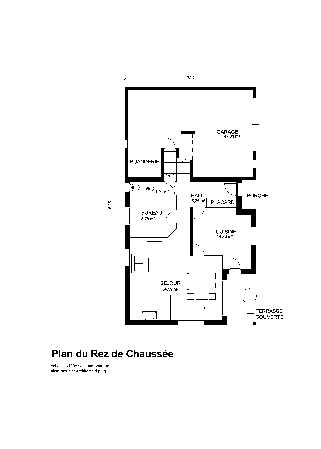

In [14]:
open_image(image_list[0]).show(figsize=(8,8))

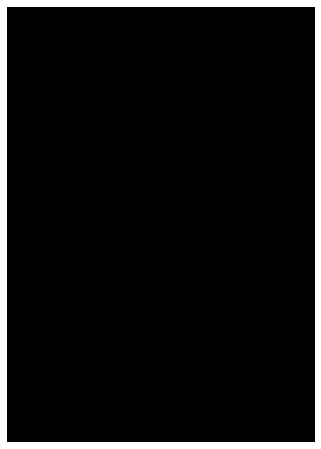

In [15]:
#mask is not a standard image file
open_image(mask_list[0]).show(figsize=(8,8))


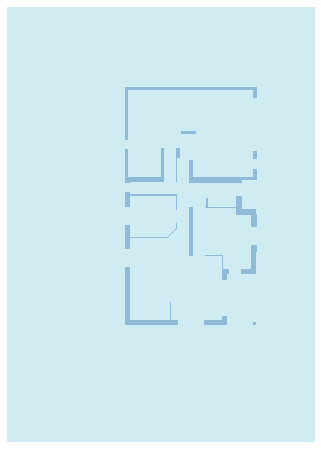

In [16]:
#fastai provides a convenient function to view masks
open_mask(mask_list[0]).show(figsize=(8,8))

In [17]:
#mask is rank 3 tensor
sample_mask = open_mask(mask_list[0])
sample_mask.shape

torch.Size([1, 3508, 2479])

### Create fastai data object with all data

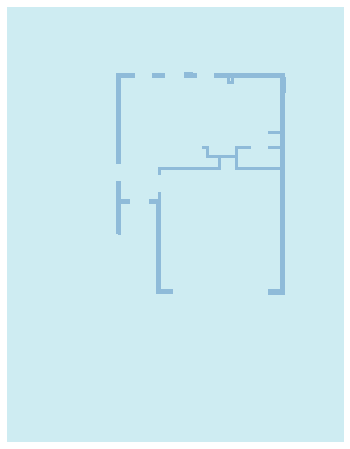

In [18]:
#To begin we require a way to tell the learner how to find the masks
#we can pass it a function which navigates from image file to mask file.

#We can crete a lambda which uses python's pathlib
path_func_image_to_mask = lambda x: mask_path/f'{x.stem}{x.suffix}'

#let test it, should return a mask
retrieved_mask = path_func_image_to_mask(image_list[120])
open_mask(retrieved_mask).show(figsize=(8,8))

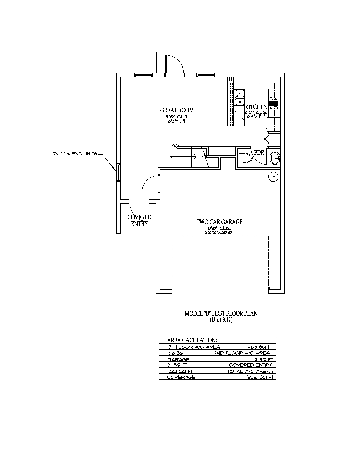

In [19]:
#compare to the orginal image manually
open_image(image_list[120]).show(figsize=(8,8))

In [20]:
#Fastai uses object to track what data we a using.
#We can keep 30% as validation set as the dataset is small.

seg_list = (SegmentationItemList
            .from_folder(image_path)
            .split_by_rand_pct(0.3, seed=99)
            .label_from_func(path_func_image_to_mask, classes=['wall', 'notawall'])
           )

In [21]:
#let us double check the resulting object
print(type(seg_list), '\n', '_ '*20, '\n')
seg_list

<class 'fastai.data_block.LabelLists'> 
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  



LabelLists;

Train: LabelList (86 items)
x: SegmentationItemList
Image (3, 3508, 2479),Image (3, 7383, 5671),Image (3, 1867, 1950),Image (3, 7383, 5671),Image (3, 3508, 2479)
y: SegmentationLabelList
ImageSegment (1, 3508, 2479),ImageSegment (1, 7383, 5671),ImageSegment (1, 1867, 1950),ImageSegment (1, 7383, 5671),ImageSegment (1, 3508, 2479)
Path: data/images;

Valid: LabelList (36 items)
x: SegmentationItemList
Image (3, 3508, 2479),Image (3, 3508, 2480),Image (3, 3300, 2550),Image (3, 2480, 3508),Image (3, 3508, 2479)
y: SegmentationLabelList
ImageSegment (1, 3508, 2479),ImageSegment (1, 3508, 2480),ImageSegment (1, 3300, 2550),ImageSegment (1, 2480, 3508),ImageSegment (1, 3508, 2479)
Path: data/images;

Test: None

In [22]:
#Transforms modify the data to aid with learning
#Let us view the standard hyper-parameters.
default_tfms = get_transforms()
default_tfms


([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

In [23]:
#Let me see if I can use my intuition to better adapt the
#transforms to the dataset.
my_tfms = get_transforms(rotate(p=0), 
                         zoom(scale=(1.2, 1.2))
                         )                                   
                                    

In [24]:
#batch size is used to control memory usage.
batch_size=4


In [25]:
#A databunch ties together the data and validation set, transforms and normalizes in a manner
#suitable for transfer learning.
databunch = (seg_list.transform(my_tfms, size=896, tfm_y=True)
            .databunch(bs=batch_size).normalize(imagenet_stats))
type(databunch)


fastai.vision.data.ImageDataBunch

In [26]:
databunch

ImageDataBunch;

Train: LabelList (86 items)
x: SegmentationItemList
Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896)
y: SegmentationLabelList
ImageSegment (1, 896, 896),ImageSegment (1, 896, 896),ImageSegment (1, 896, 896),ImageSegment (1, 896, 896),ImageSegment (1, 896, 896)
Path: data/images;

Valid: LabelList (36 items)
x: SegmentationItemList
Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896)
y: SegmentationLabelList
ImageSegment (1, 896, 896),ImageSegment (1, 896, 896),ImageSegment (1, 896, 896),ImageSegment (1, 896, 896),ImageSegment (1, 896, 896)
Path: data/images;

Test: None

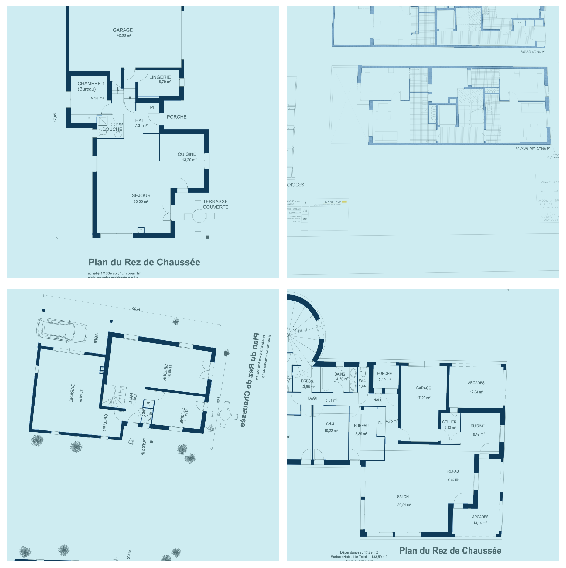

In [27]:
databunch.show_batch(2, figsize=(8,8))

### Create model

In [28]:
#weight decay - around 0.02 is tested be ideal for almost all datasets. 
wd=2e-2

In [29]:
#Dice is the standard metric for segmentation.
learner = unet_learner(databunch, models.resnet34, metrics=dice, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


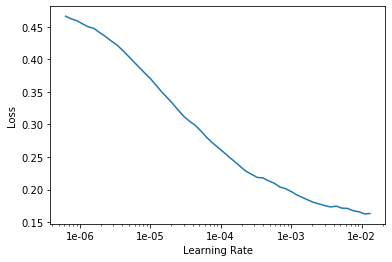

In [30]:
#plotting learning rate vs. error rate allows us to better
#set the initial learning rate
lr_find(learner)
learner.recorder.plot()

### Initial Training

In [31]:
learner.fit_one_cycle(10, 1e-04, pct_start=0.5)

epoch,train_loss,valid_loss,dice,time
0,0.206649,0.119421,0.982037,00:48
1,0.124695,0.063283,0.990349,00:49
2,0.089776,0.057469,0.988599,00:46
3,0.069855,0.041804,0.992610,00:47
4,0.055199,0.031497,0.993649,00:49
5,0.044376,0.026559,0.994839,00:48
6,0.036363,0.026836,0.994958,00:49
7,0.030797,0.028518,0.994790,00:50
8,0.026599,0.025021,0.995362,00:48
9,0.024046,0.025630,0.995319,00:48


In [32]:
learner.save('Basic Training')

### Fine Tuning

In [33]:
#The learner crashes here the GPU cache is not clearing
#properly. Manual garbage collection seems to help.
gc.collect()

6367

In [35]:
learner.load('Basic Training')

Learner(data=ImageDataBunch;

Train: LabelList (86 items)
x: SegmentationItemList
Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896)
y: SegmentationLabelList
ImageSegment (1, 896, 896),ImageSegment (1, 896, 896),ImageSegment (1, 896, 896),ImageSegment (1, 896, 896),ImageSegment (1, 896, 896)
Path: data/images;

Valid: LabelList (36 items)
x: SegmentationItemList
Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896)
y: SegmentationLabelList
ImageSegment (1, 896, 896),ImageSegment (1, 896, 896),ImageSegment (1, 896, 896),ImageSegment (1, 896, 896),ImageSegment (1, 896, 896)
Path: data/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(

In [37]:
#unfreeze the pretrained weights
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


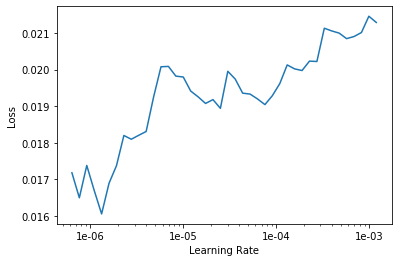

In [38]:
lr_find(learner)
learner.recorder.plot()

In [39]:
lr = slice(1e-06, 1e-04)

In [40]:
learner.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,dice,time
0,0.019947,0.033753,0.994923,00:48
1,0.020781,0.029566,0.994959,00:49
2,0.019332,0.021516,0.996005,00:47
3,0.017711,0.023669,0.995801,00:48


In [41]:
#let us try a even finer learning ratae
lr = slice(1e-07, 1e-05)

In [42]:
learner.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,dice,time
0,0.015739,0.022301,0.996064,00:48
1,0.015369,0.024864,0.995845,00:47
2,0.015422,0.022743,0.996029,00:51
3,0.015188,0.023738,0.995965,00:48


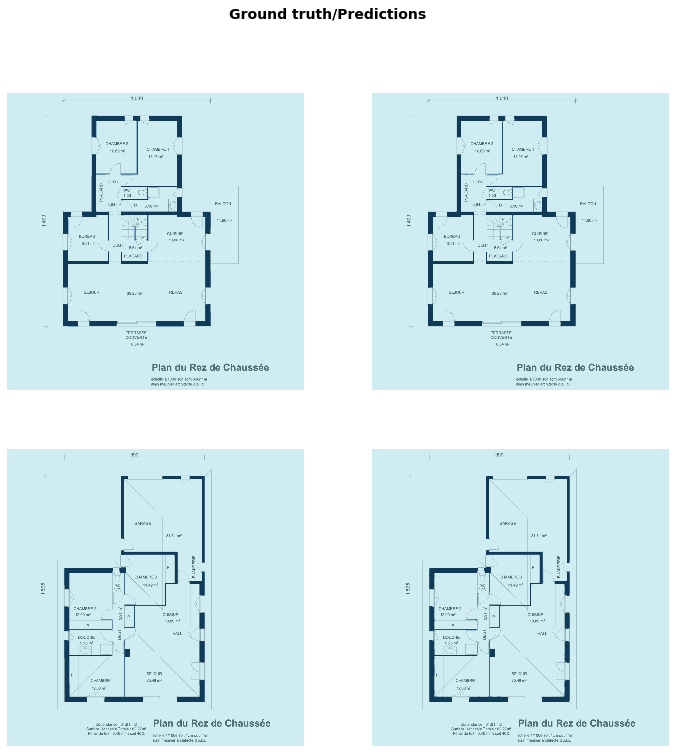

In [47]:
#It will be difficult to visually detect differences as
#0.4% of pixels differ.
learner.show_results(rows=2, figsize=(12,12))

### Conclusion: 

Despite that it is an easy task, the final accuracy(dice) is far better<br>
than is needed for using the model to automate the extracting of walls<br>
(and presumably other features) off of house plans.